<a href="https://colab.research.google.com/github/sgathai/dsc-data-serialization-lab/blob/master/Copy_of_detecting_multicollinearity_Linear_regression_tips.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example: Detecting multicollinearity

We will once again use our university admission [dataset](https://drive.google.com/file/d/13HPgfc4HP9UP-gHM2lutJ7MXSt-dAL1d/view)

First, let's understand how our independent variables are correlated to each other

In [ ]:
import numpy as np
import pandas as pd

# Load the dataset
data = pd.read_csv('uni_admission.csv')

# Remove the serial and admit chance columns, we want to focus on our independent variables only.
independent_only = data.drop(columns=['Serial No.', 'admit_chance'])

# Let's display the correlations between the variables
correlations = independent_only.corr()

correlations

,GRE,TOEFL,uni_rating,SOP,LOR,CGPA,publications
GRE,1.000000,0.827200,0.635376,0.613498,0.524679,0.825878,0.563398
TOEFL,0.827200,1.000000,0.649799,0.644410,0.541563,0.810574,0.467012
uni_rating,0.635376,0.649799,1.000000,0.728024,0.608651,0.705254,0.427047
SOP,0.613498,0.644410,0.728024,1.000000,0.663707,0.712154,0.408116
LOR,0.524679,0.541563,0.608651,0.663707,1.000000,0.637469,0.372526
CGPA,0.825878,0.810574,0.705254,0.712154,0.637469,1.000000,0.501311
publications,0.563398,0.467012,0.427047,0.408116,0.372526,0.501311,1.000000


The tabe above shows us how each variable relates to another. The coefficient of 1 across the diagonal makes sense, as a variable is perfectly correlated to itself. Let's use these correlations to compute the VIF score for each variable. This will require a little bit of linear algebra, but the approach is straightforward: we create a new dataframe with the *inverse* of the matrix above.

In [ ]:
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)


,GRE,TOEFL,uni_rating,SOP,LOR,CGPA,publications
GRE,4.464249,-1.919309,-0.167441,0.115539,0.163716,-1.829666,-0.738214
TOEFL,-1.919309,3.904213,-0.280590,-0.320530,0.008925,-1.216918,0.115389
uni_rating,-0.167441,-0.280590,2.621036,-1.003439,-0.326820,-0.504916,-0.109544
SOP,0.115539,-0.320530,-1.003439,2.835210,-0.715324,-0.670228,-0.041512
LOR,0.163716,0.008925,-0.326820,-0.715324,2.033555,-0.650578,-0.096312
CGPA,-1.829666,-1.216918,-0.504916,-0.670228,-0.650578,4.777992,-0.064604
publications,-0.738214,0.115389,-0.109544,-0.041512,-0.096312,-0.064604,1.494008


Interpreting the table is straightforward: The VIF score for each variable is found alongside the downwards sloping diagonal. GRE has a score of 4.46, TOEFL has a score of 3.9, uni_rating a score of 2.62, etc.

CGPA has a value nearing 5, let's see how the VIF scores improve if we remove it from our dataset

In [ ]:
revised = independent_only.drop(columns=['CGPA'])

correlations = revised.corr()
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)



,GRE,TOEFL,uni_rating,SOP,LOR,publications
GRE,3.763604,-2.385311,-0.360792,-0.141115,-0.085414,-0.762953
TOEFL,-2.385311,3.594274,-0.409188,-0.491232,-0.156772,0.098934
uni_rating,-0.360792,-0.409188,2.567679,-1.074266,-0.395570,-0.116371
SOP,-0.141115,-0.491232,-1.074266,2.741195,-0.806583,-0.050574
LOR,-0.085414,-0.156772,-0.395570,-0.806583,1.944971,-0.105109
publications,-0.762953,0.098934,-0.116371,-0.050574,-0.105109,1.493134


All scores dropped, but the GRE's in particular did quite a bit, indicating that GRE and CGPA were colinear.

# Example 2: Residual plots and heteroskedasticity testing

Let's start by creating a model based on our revised set of independent variables above, then displaying the residual plot for it.

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = revised.values
y = data['admit_chance'].values

X_train, X_test, admit_train, admit_test = train_test_split(X, y, test_size=0.2, random_state=0)

regressor = LinearRegression()
regressor.fit(X_train, admit_train)

# This is our prediction for admission based on our model
admit_predict = regressor.predict(X_test)

# We now create the residual by substracting the test value from the predicted
# value for each row in our dataset

residuals = np.subtract(admit_predict, admit_test)

# Let's describe our residual:
pd.DataFrame(residuals).describe()

residuals.mean()

-0.0017516644688065042

Before we interpret the description above, let's recall what we are trying to predict: The percentage chance of admission to university. This means values between 0 and 1.

Our min and max for the residual are fairly high: they suggest we've been up to 26% off target. It's important for us to plot this first: Is this a common occurence, or a few outliers?

Our mean on the other hand is close to 0, indicating that we tend to be fairly correct, although slightly over estimating chances by, on average, 0.17%

Let's show the residual plot

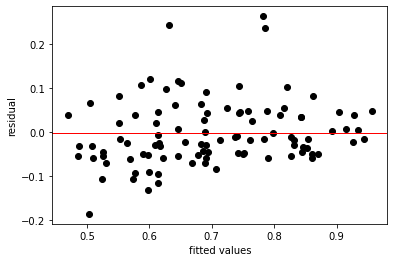

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(admit_predict, residuals, color='black')
plt.ylabel('residual')
plt.xlabel('fitted values')
plt.axhline(y= residuals.mean(), color='red', linewidth=1)
plt.show()

This does not look too bad: our residuals are centered around a mean that is very close to 0, and there are no glaringly obvious patterns. Let's be thorough though, and perform a heteroskedasticity test.

For this we will use [bartlett's test](https://www.itl.nist.gov/div898/handbook/eda/section3/eda357.htm). The test establishes as a null hypothesis that the variance is equal for all our datapoints,and the new hypothesis that the variance is different for at least one pair of datapoints.


In [ ]:
import scipy as sp

test_result, p_value = sp.stats.bartlett(admit_predict, residuals)

# To interpret the results we must also compute a critical value of the chi squared distribution
degree_of_freedom = len(admit_predict)-1
probability = 1 - p_value

critical_value = sp.stats.chi2.ppf(probability, degree_of_freedom)
print(critical_value)

# If the test_result is greater than the critical value, then we reject our null
# hypothesis. This would mean that there are patterns to the variance of the data

# Otherwise, we can identify no patterns, and we accept the null hypothesis that
# the variance is homogeneous across our data

if (test_result > critical_value):
  print('the variances are unequal, and the model should be reassessed')
else:
  print('the variances are homogeneous!')



185.4720823514965
the variances are homogeneous!


# Challenge

We will bring this all together by adapting a challenge from data.world. In the code section below you have access to a large dataset with demographic and medical data for cancer occurances in regions in the US. Your aim is to build a model that predicts the **target_deathrate** variable. You can find descriptions of all the columns [here](https://data.world/exercises/linear-regression-exercise-1)

This is a holistic challenge:


*   Make sure to clean up your data first, there are some missing elements.
*   Some data should be changed: Add a **state** column which indicates the state a person lives in(you can modify the geography column). Perform a multicollinearity test: Should **state** be included in your model or not?
* If it should be, make sure to transform it since we want to be dealing with numerical data.
* Build a model, then display the residual plot for it. Perform a Bartlett test to determine if your model is acceptable or not.





In [ ]:
# Your code goes here!
df = pd.read_csv('https://query.data.world/s/4n3rdrpeu6qrfo63yacah7v3ofoaag')
df

,avganncount,avgdeathsperyear,target_deathrate,incidencerate,medincome,popest2015,povertypercent,studypercap,binnedinc,medianage,medianagemale,medianagefemale,geography,percentmarried,pctnohs18_24,pcths18_24,pctsomecol18_24,pctbachdeg18_24,pcths25_over,pctbachdeg25_over,pctemployed16_over,pctunemployed16_over,pctprivatecoverage,pctprivatecoveragealone,pctempprivcoverage,pctpubliccoverage,pctpubliccoveragealone,pctwhite,pctblack,pctasian,pctotherrace,pctmarriedhouseholds,birthrate
0,1397.000000,469,164.9,489.800000,61898,260131,11.2,499.748204,"(61494.5, 125635]",39.3,36.9,41.7,"Kitsap County, Washington",52.5,11.5,39.5,42.1,6.9,23.2,19.6,51.9,8.0,75.1,NaN,41.6,32.9,14.0,81.780529,2.594728,4.821857,1.843479,52.856076,6.118831
1,173.000000,70,161.3,411.600000,48127,43269,18.6,23.111234,"(48021.6, 51046.4]",33.0,32.2,33.7,"Kittitas County, Washington",44.5,6.1,22.4,64.0,7.5,26.0,22.7,55.9,7.8,70.2,53.8,43.6,31.1,15.3,89.228509,0.969102,2.246233,3.741352,45.372500,4.333096
2,102.000000,50,174.7,349.700000,49348,21026,14.6,47.560164,"(48021.6, 51046.4]",45.0,44.0,45.8,"Klickitat County, Washington",54.2,24.0,36.6,NaN,9.5,29.0,16.0,45.9,7.0,63.7,43.5,34.9,42.1,21.1,90.922190,0.739673,0.465898,2.747358,54.444868,3.729488
3,427.000000,202,194.8,430.400000,44243,75882,17.1,342.637253,"(42724.4, 45201]",42.8,42.2,43.4,"Lewis County, Washington",52.7,20.2,41.2,36.1,2.5,31.6,9.3,48.3,12.1,58.4,40.3,35.0,45.3,25.0,91.744686,0.782626,1.161359,1.362643,51.021514,4.603841
4,57.000000,26,144.4,350.100000,49955,10321,12.5,0.000000,"(48021.6, 51046.4]",48.3,47.8,48.9,"Lincoln County, Washington",57.8,14.9,43.0,40.0,2.0,33.4,15.0,48.2,4.8,61.6,43.9,35.1,44.0,22.7,94.104024,0.270192,0.665830,0.492135,54.027460,6.796657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3042,1962.667684,15,149.6,453.549422,46961,6343,12.4,0.000000,"(45201, 48021.6]",44.2,41.1,48.8,"Ellsworth County, Kansas",51.0,20.9,27.9,NaN,8.4,32.2,15.2,51.7,4.3,78.3,54.9,44.6,31.7,13.2,90.280811,3.837754,0.327613,1.700468,51.063830,7.773512
3043,1962.667684,43,150.1,453.549422,48609,37118,18.8,377.175494,"(48021.6, 51046.4]",30.4,29.3,31.4,"Finney County, Kansas",52.6,26.7,33.9,35.6,3.8,23.1,12.4,70.1,4.6,64.5,53.3,48.6,28.8,17.7,75.706245,2.326771,4.044920,14.130288,52.007937,8.186470
3044,1962.667684,46,153.9,453.549422,51144,34536,15.0,1968.959926,"(51046.4, 54545.6]",30.9,30.5,31.2,"Ford County, Kansas",54.8,19.7,44.5,33.3,2.5,23.0,12.8,64.8,6.4,62.0,52.6,47.8,26.6,16.8,87.961629,2.313188,1.316472,5.680705,55.153949,7.809192
3045,1962.667684,52,175.0,453.549422,50745,25609,13.3,0.000000,"(48021.6, 51046.4]",39.0,36.9,40.5,"Franklin County, Kansas",58.8,10.9,37.2,NaN,4.1,36.1,14.4,NaN,6.9,75.9,56.3,49.6,29.5,14.0,92.905681,1.176562,0.244632,2.131790,58.484232,7.582938
